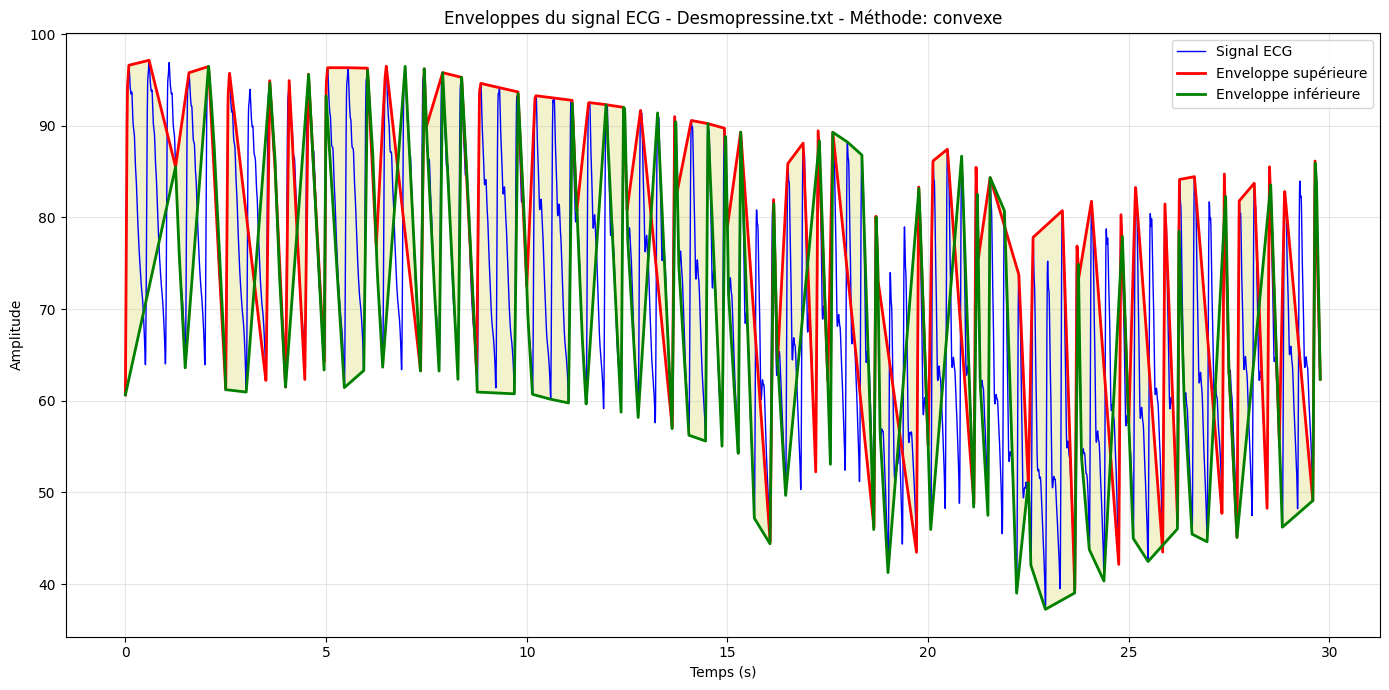

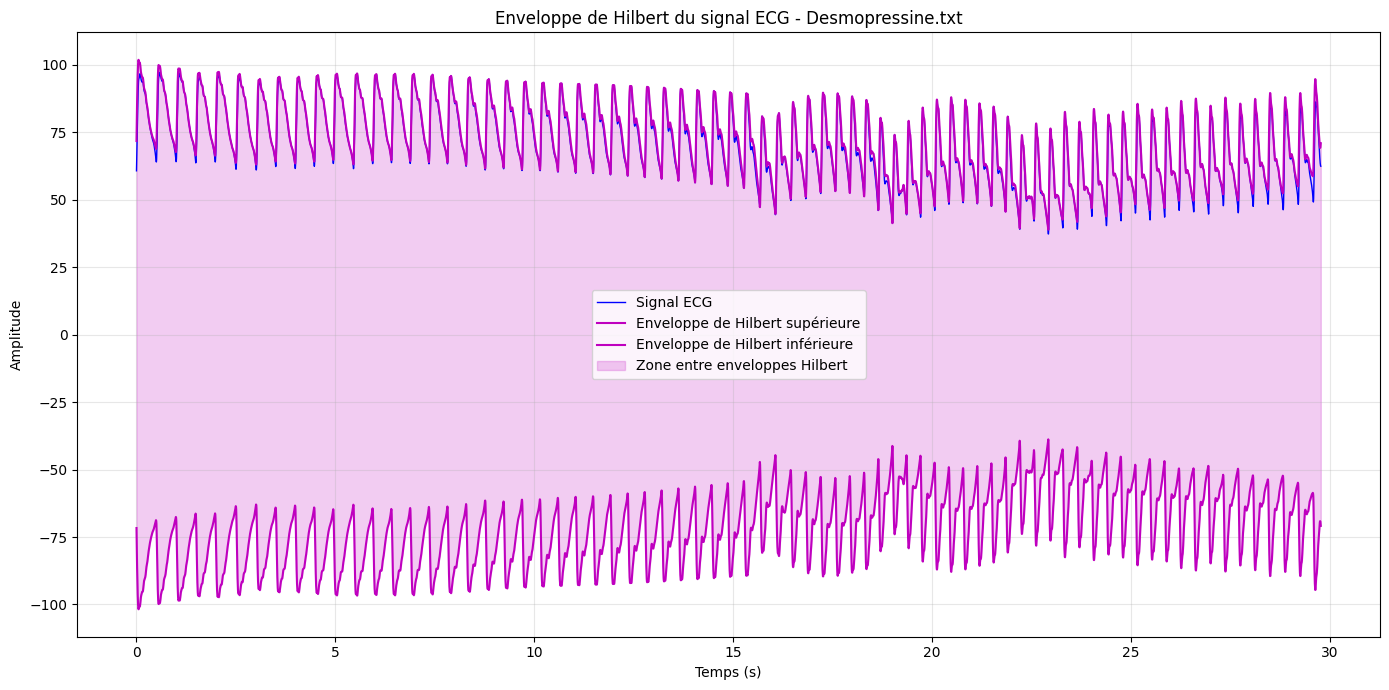

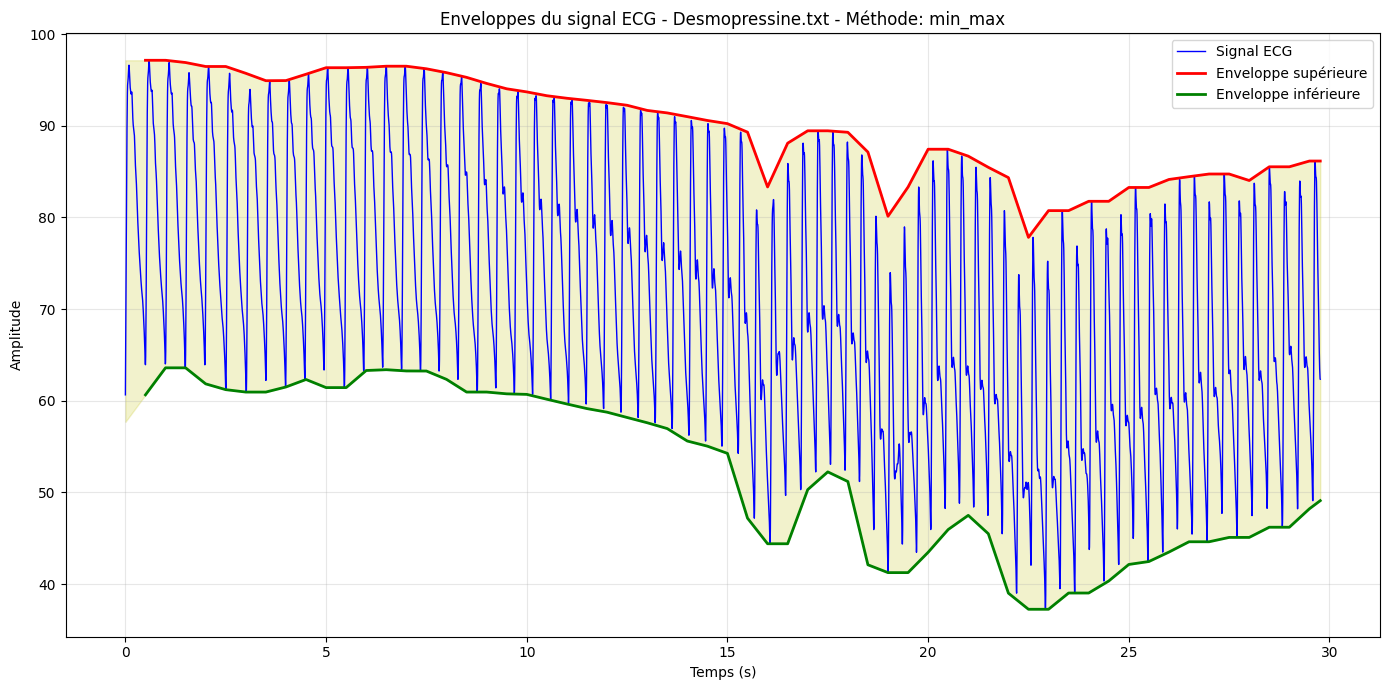

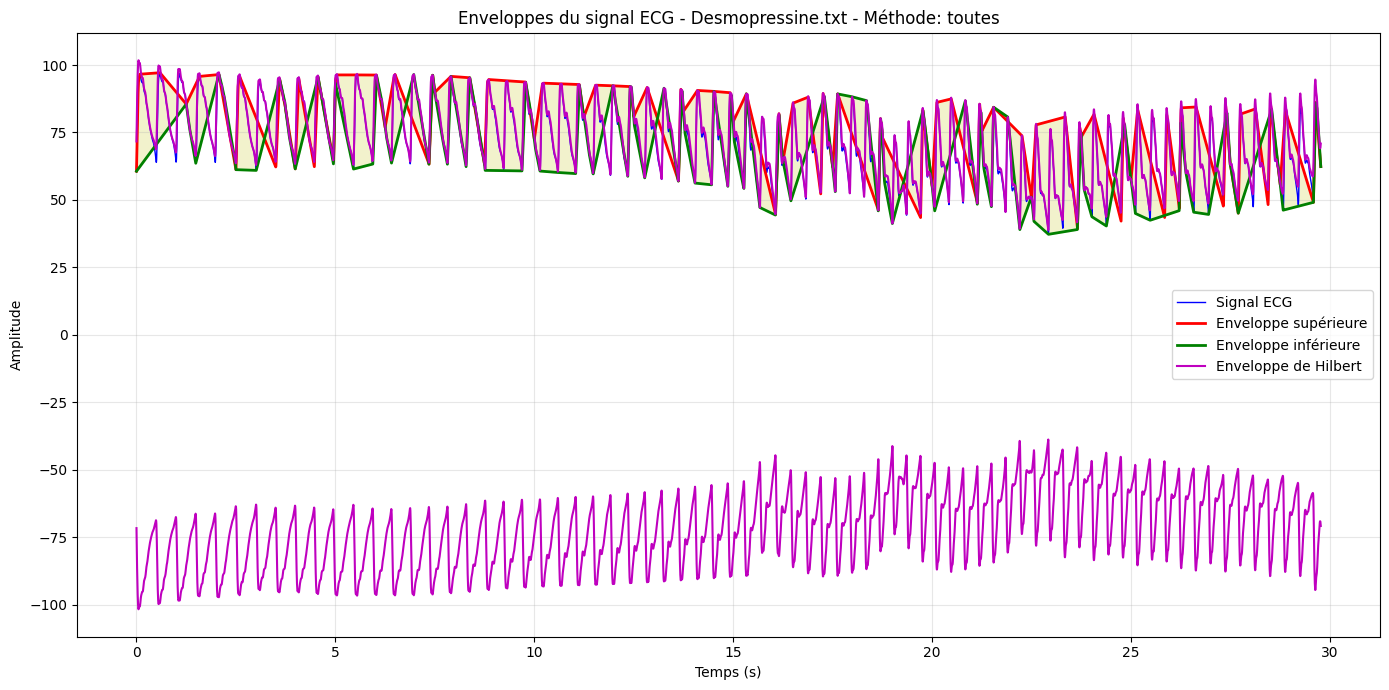

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, savgol_filter
from scipy.spatial import ConvexHull
import pandas as pd

def charger_donnees_ecg(fichier, encodage='latin1'):
    """
    Charge les données ECG à partir d'un fichier.
    
    Args:
        fichier: Chemin vers le fichier de données
        encodage: Encodage du fichier
    """
    try:
        data = pd.read_csv(fichier, sep="\t", header=None, decimal=',', encoding=encodage)
        # Suppose que le signal ECG est dans la deuxième colonne (index 1)
        return data.iloc[:, 1].values
    except UnicodeDecodeError:
        # Si l'encodage par défaut échoue, essayer d'autres encodages courants
        encodages_possibles = ['cp1252', 'ISO-8859-1', 'utf-16', 'utf-8-sig']
        for enc in encodages_possibles:
            try:
                print(f"Tentative avec l'encodage {enc}...")
                data = pd.read_csv(fichier, sep="\t", header=None, decimal=',', encoding=enc)
                return data.iloc[:, 1].values
            except UnicodeDecodeError:
                continue
        
        # Si tous les encodages échouent, essayer de lire en mode binaire
        print("Tentative de lecture en mode binaire...")
        try:
            # Essayer de charger comme un fichier binaire
            data = np.loadtxt(fichier, delimiter='\t', usecols=[1])
            return data
        except:
            raise ValueError(f"Impossible de lire le fichier {fichier} avec les encodages courants")

def filtrer_signal(signal, frequence_echantillonnage=200):
    """
    Filtre le signal ECG pour réduire le bruit.
    
    Args:
        signal: Signal ECG brut
        frequence_echantillonnage: Fréquence d'échantillonnage en Hz
    """
    # Appliquer un filtre Savitzky-Golay pour lisser le signal
    # La taille de la fenêtre et l'ordre polynomial peuvent être ajustés selon le bruit du signal
    taille_fenetre = 15  # Doit être impair
    ordre = 3  # Ordre polynomial du filtre
    signal_filtre = savgol_filter(signal, taille_fenetre, ordre)
    
    return signal_filtre

def calculer_enveloppe_hilbert(signal):
    """
    Calcule l'enveloppe du signal en utilisant la transformation de Hilbert.
    Cette méthode est adaptée pour suivre l'amplitude du signal.
    
    Args:
        signal: Signal ECG (brut ou filtré)
    """
    # Calculer le signal analytique (signal complexe)
    signal_analytique = hilbert(signal)
    
    # Calculer l'amplitude instantanée (module du signal analytique)
    enveloppe = np.abs(signal_analytique)
    
    return enveloppe

def calculer_enveloppe_convexe(temps, signal, fenetre=500, chevauchement=0.5):
    """
    Calcule l'enveloppe convexe du signal ECG en utilisant l'algorithme de l'enveloppe convexe
    sur des segments du signal, puis en les combinant.
    
    Args:
        temps: Vecteur temps
        signal: Signal ECG (brut ou filtré)
        fenetre: Taille de la fenêtre glissante (nombre d'échantillons)
        chevauchement: Pourcentage de chevauchement entre les fenêtres
    """
    n = len(signal)
    pas = int(fenetre * (1 - chevauchement))
    
    # Points pour l'enveloppe supérieure et inférieure
    points_sup = []
    points_inf = []
    
    # Traiter le signal par segments avec une fenêtre glissante
    for debut in range(0, n, pas):
        fin = min(debut + fenetre, n)
        
        # Extraire le segment
        segment_temps = temps[debut:fin]
        segment_signal = signal[debut:fin]
        
        # Créer les points 2D pour ce segment
        points = np.column_stack((segment_temps, segment_signal))
        
        if len(points) >= 3:  # ConvexHull nécessite au moins 3 points
            try:
                # Calculer l'enveloppe convexe pour ce segment
                hull = ConvexHull(points)
                
                # Trier les points de l'enveloppe par leur position en x (temps)
                vertices = hull.vertices
                vertices = vertices[np.argsort(points[vertices, 0])]
                
                # Séparer les points en enveloppe supérieure et inférieure
                for i in range(len(vertices)):
                    x, y = points[vertices[i]]
                    if i == 0 or i == len(vertices) - 1 or y > points[vertices[i-1], 1]:
                        points_sup.append((x, y))
                    if i == 0 or i == len(vertices) - 1 or y < points[vertices[i-1], 1]:
                        points_inf.append((x, y))
            except:
                # Si ConvexHull échoue (par exemple, points colinéaires), utiliser min et max
                points_sup.append((segment_temps[0], segment_signal[0]))
                points_sup.append((segment_temps[-1], segment_signal[-1]))
                points_inf.append((segment_temps[0], segment_signal[0]))
                points_inf.append((segment_temps[-1], segment_signal[-1]))
    
    # Trier les points par temps
    points_sup = sorted(points_sup, key=lambda p: p[0])
    points_inf = sorted(points_inf, key=lambda p: p[0])
    
    # Convertir en tableaux numpy
    enveloppe_sup = np.array(points_sup)
    enveloppe_inf = np.array(points_inf)
    
    return enveloppe_sup, enveloppe_inf

def calculer_enveloppe_min_max(temps, signal, fenetre=200):
    """
    Calcule une enveloppe simple en utilisant les valeurs min et max dans une fenêtre glissante.
    
    Args:
        temps: Vecteur temps
        signal: Signal ECG (brut ou filtré)
        fenetre: Taille de la fenêtre glissante (nombre d'échantillons)
    """
    n = len(signal)
    temps_envelope = []
    enveloppe_sup = []
    enveloppe_inf = []
    
    for i in range(0, n, fenetre//2):
        segment = signal[i:min(i+fenetre, n)]
        if len(segment) > 0:
            t = temps[min(i+fenetre//2, n-1)]
            temps_envelope.append(t)
            enveloppe_sup.append(np.max(segment))
            enveloppe_inf.append(np.min(segment))
    
    return np.column_stack((temps_envelope, enveloppe_sup)), np.column_stack((temps_envelope, enveloppe_inf))

def tracer_enveloppes(temps, signal, enveloppe_sup=None, enveloppe_inf=None, enveloppe_hilbert=None, titre="Enveloppes du signal ECG"):
    """
    Trace le signal ECG avec ses différentes enveloppes.
    
    Args:
        temps: Vecteur temps
        signal: Signal ECG
        enveloppe_sup: Points de l'enveloppe supérieure (peut être None)
        enveloppe_inf: Points de l'enveloppe inférieure (peut être None)
        enveloppe_hilbert: Enveloppe calculée avec la transformation de Hilbert (optionnel)
        titre: Titre du graphique
    """
    plt.figure(figsize=(14, 7))
    
    # Tracer le signal original
    plt.plot(temps, signal, 'b-', linewidth=1, label='Signal ECG')
    
    # Tracer l'enveloppe convexe si fournie
    if enveloppe_sup is not None and len(enveloppe_sup) > 0:
        plt.plot(enveloppe_sup[:, 0], enveloppe_sup[:, 1], 'r-', linewidth=2, label='Enveloppe supérieure')
    
    if enveloppe_inf is not None and len(enveloppe_inf) > 0:
        plt.plot(enveloppe_inf[:, 0], enveloppe_inf[:, 1], 'g-', linewidth=2, label='Enveloppe inférieure')
    
    # Tracer l'enveloppe de Hilbert si fournie
    if enveloppe_hilbert is not None:
        plt.plot(temps, enveloppe_hilbert, 'm-', linewidth=1.5, label='Enveloppe de Hilbert')
        plt.plot(temps, -enveloppe_hilbert, 'm-', linewidth=1.5)
    
    plt.title(titre)
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Ajouter la zone entre les enveloppes
    if enveloppe_sup is not None and enveloppe_inf is not None and len(enveloppe_sup) > 0 and len(enveloppe_inf) > 0:
        # Créer une interpolation pour avoir des points aux mêmes valeurs de temps
        from scipy.interpolate import interp1d
        
        # Temps commun pour l'interpolation (utiliser le temps du signal original)
        t_interp = temps
        
        # Interpoler les enveloppes sur le temps commun
        if len(enveloppe_sup) >= 2 and len(enveloppe_inf) >= 2:
            try:
                f_sup = interp1d(enveloppe_sup[:, 0], enveloppe_sup[:, 1], 
                                kind='linear', bounds_error=False, fill_value="extrapolate")
                f_inf = interp1d(enveloppe_inf[:, 0], enveloppe_inf[:, 1], 
                                kind='linear', bounds_error=False, fill_value="extrapolate")
                
                # Calculer les valeurs interpolées
                sup_interp = f_sup(t_interp)
                inf_interp = f_inf(t_interp)
                
                # Remplir la zone entre les enveloppes
                plt.fill_between(t_interp, inf_interp, sup_interp, color='y', alpha=0.2, 
                                label='Zone entre enveloppes')
            except:
                print("Avertissement: Impossible d'interpoler les enveloppes pour remplir la zone")
    
    plt.tight_layout()
    plt.show()

def tracer_enveloppe_hilbert(temps, signal, enveloppe_hilbert, titre="Enveloppe de Hilbert du signal ECG"):
    """
    Trace spécifiquement l'enveloppe de Hilbert du signal ECG.
    
    Args:
        temps: Vecteur temps
        signal: Signal ECG
        enveloppe_hilbert: Enveloppe calculée avec la transformation de Hilbert
        titre: Titre du graphique
    """
    plt.figure(figsize=(14, 7))
    
    # Tracer le signal original
    plt.plot(temps, signal, 'b-', linewidth=1, label='Signal ECG')
    
    # Tracer l'enveloppe de Hilbert
    plt.plot(temps, enveloppe_hilbert, 'm-', linewidth=1.5, label='Enveloppe de Hilbert supérieure')
    plt.plot(temps, -enveloppe_hilbert, 'm-', linewidth=1.5, label='Enveloppe de Hilbert inférieure')
    
    # Remplir la zone entre les enveloppes
    plt.fill_between(temps, -enveloppe_hilbert, enveloppe_hilbert, color='m', alpha=0.2, 
                    label='Zone entre enveloppes Hilbert')
    
    plt.title(titre)
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyser_enveloppe_ecg(fichier, frequence_echantillonnage=200, methode="convexe"):
    """
    Fonction principale qui coordonne l'analyse de l'enveloppe du signal ECG.
    
    Args:
        fichier: Chemin vers le fichier de données ECG
        frequence_echantillonnage: Fréquence d'échantillonnage en Hz
        methode: Méthode d'enveloppe à utiliser ('convexe', 'hilbert', 'min_max' ou 'toutes')
    """
    # Charger les données
    signal_ecg = charger_donnees_ecg(fichier)
    
    # Filtrer le signal pour réduire le bruit
    signal_filtre = filtrer_signal(signal_ecg, frequence_echantillonnage)
    
    # Créer le vecteur temps
    temps = np.arange(len(signal_filtre)) / frequence_echantillonnage
    
    # Variables pour stocker les enveloppes
    enveloppe_sup = None
    enveloppe_inf = None
    enveloppe_hilbert = None
    
    # Calculer les enveloppes selon la méthode choisie
    if methode in ["convexe", "toutes"]:
        enveloppe_sup, enveloppe_inf = calculer_enveloppe_convexe(temps, signal_filtre)
    
    if methode in ["min_max", "toutes"]:
        if enveloppe_sup is None or len(enveloppe_sup) < 2:
            enveloppe_sup, enveloppe_inf = calculer_enveloppe_min_max(temps, signal_filtre)
        else:
            # Si on fait toutes les méthodes, utiliser min_max comme fallback pour l'interpolation
            env_sup_mm, env_inf_mm = calculer_enveloppe_min_max(temps, signal_filtre)
            if len(enveloppe_sup) < 2 or len(enveloppe_inf) < 2:
                enveloppe_sup, enveloppe_inf = env_sup_mm, env_inf_mm
    
    if methode in ["hilbert", "toutes"]:
        enveloppe_hilbert = calculer_enveloppe_hilbert(signal_filtre)
        
        # Si on utilise uniquement la méthode de Hilbert, créer des enveloppes min-max pour l'affichage
        if methode == "hilbert" and enveloppe_sup is None:
            # Utiliser l'enveloppe min-max comme substitut pour l'affichage
            enveloppe_sup, enveloppe_inf = calculer_enveloppe_min_max(temps, signal_filtre)
    
    # Tracer les résultats selon la méthode
    if methode == "hilbert":
        # Tracer spécifiquement l'enveloppe de Hilbert
        tracer_enveloppe_hilbert(temps, signal_filtre, enveloppe_hilbert, 
                               titre=f"Enveloppe de Hilbert du signal ECG - {fichier}")
    else:
        # Tracer avec toutes les enveloppes disponibles
        tracer_enveloppes(temps, signal_filtre, enveloppe_sup, enveloppe_inf, 
                        enveloppe_hilbert if methode in ["hilbert", "toutes"] else None,
                        titre=f"Enveloppes du signal ECG - {fichier} - Méthode: {methode}")
    
    return {
        'signal_original': signal_ecg,
        'signal_filtre': signal_filtre,
        'temps': temps,
        'enveloppe_superieure': enveloppe_sup,
        'enveloppe_inferieure': enveloppe_inf,
        'enveloppe_hilbert': enveloppe_hilbert
    }

# Exemple d'utilisation
if __name__ == "__main__":
    # Analyser avec l'enveloppe convexe (méthode par défaut)
    resultat_convexe = analyser_enveloppe_ecg("Desmopressine.txt", methode="convexe")
    
    # Analyser avec l'enveloppe de Hilbert
    resultat_hilbert = analyser_enveloppe_ecg("Desmopressine.txt", methode="hilbert")
    
    # Analyser avec l'approche min-max
    resultat_min_max = analyser_enveloppe_ecg("Desmopressine.txt", methode="min_max")
    
    # Analyser avec toutes les méthodes combinées
    resultat_toutes = analyser_enveloppe_ecg("Desmopressine.txt", methode="toutes")